In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv

/home/rishukumar/Documents/CampusX/CampusX_Code/LangGraph_CampusX/myenv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
load_dotenv()

True

In [3]:
class SubState(TypedDict):

    input_text: str
    translated_text: str

In [4]:
subgraph_llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash"
)

E0000 00:00:1766859991.118279   36155 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [5]:
def translate_text(state: SubState):

    prompt = f"""
Translate the following text to Hindi.
Keep it natural and clear. Do not add extra content.

Text:
{state["input_text"]}
""".strip()
    
    translated_text = subgraph_llm.invoke(prompt).content

    return {'translated_text': translated_text}

In [6]:
subgraph_builder = StateGraph(SubState)

subgraph_builder.add_node('translate_text', translate_text)

subgraph_builder.add_edge(START, 'translate_text')
subgraph_builder.add_edge('translate_text', END)

subgraph = subgraph_builder.compile()

In [7]:
class ParentState(TypedDict):

    question: str
    answer_eng: str
    answer_hin: str

In [8]:
parent_llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash"
)

E0000 00:00:1766860041.060519   36155 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [10]:
def generate_answer(state: ParentState):

    answer = parent_llm.invoke(f"You are a helpful assistant. Answer clearly.\n\nQuestion: {state['question']}").content
    return {'answer_eng': answer}

In [11]:
def translate_answer(state: ParentState):

    # call the subgraph
    result = subgraph.invoke({'input_text': state['answer_eng']})

    return {'answer_hin': result['translated_text']}

In [12]:
parent_builder = StateGraph(ParentState)

parent_builder.add_node("answer", generate_answer)
parent_builder.add_node("translate", translate_answer)

parent_builder.add_edge(START, 'answer')
parent_builder.add_edge('answer', 'translate')
parent_builder.add_edge('translate', END)

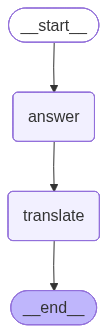

In [13]:
graph = parent_builder.compile()
graph

In [14]:
graph.invoke({'question': 'What is quantum physics'})

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


{'question': 'What is quantum physics',
 'answer_eng': 'Quantum physics is the branch of physics that studies matter and energy at the most fundamental level. It describes how the universe behaves at the scale of atoms and subatomic particles, where the rules of classical physics (which govern the everyday world) break down.\n\nHere\'s a breakdown of what that means:\n\n1.  **The "Quantum" Part:**\n    The word "quantum" comes from the Latin word for "how much." In quantum physics, it refers to the idea that physical quantities like energy, momentum, and angular momentum don\'t exist in continuous amounts, but rather in discrete, indivisible packets called **quanta**.\n    *   **Analogy:** Think of a staircase versus a ramp. On a ramp, you can stop at any height. On a staircase, you can only be on one step or another; you can\'t be in between steps. Energy in the quantum world is like the steps on a staircase.\n    *   **Example:** Light, for instance, is not a continuous wave of energ

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
